In [ ]:
import numpy as np
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

class FashionCBIR:
    def __init__(self, base_dir, image_size=(224, 224)):
        self.image_size = image_size
        self.base_dir = base_dir
        self.product_database = []
        self.feature_database = None
        self.history = None
        self.label_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]

        # Initialize VGG16 model
        self.base_model = VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(image_size[0], image_size[1], 3))

        # Freeze the convolutional base
        for layer in self.base_model.layers:
            layer.trainable = False

        # Build feature extractor using VGG16
        input_tensor = Input(shape=(image_size[0], image_size[1], 3))
        x = self.base_model(input_tensor)
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.3)(x)
        feature_output = Dense(256, activation='relu')(x)

        # Feature extractor model
        self.model = Model(inputs=input_tensor, outputs=feature_output)

        # Classification model
        classification_output = Dense(len(self.label_names), activation='softmax')(feature_output)
        self.classifier = Model(inputs=input_tensor, outputs=classification_output)

        # Compile the classification model
        self.classifier.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def prepare_fashion_mnist(self):
        """Load and prepare Fashion-MNIST dataset"""
        print("Loading Fashion-MNIST dataset...")
        (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

        # Store original labels for evaluation
        self.train_labels = train_labels
        self.test_labels = test_labels

        # Create directories for each category
        for label in self.label_names:
            category_dir = os.path.join(self.base_dir, label.replace("/", "-"))
            os.makedirs(category_dir, exist_ok=True)

        print("Saving training images...")
        self._save_dataset_images(train_images, train_labels, "train")

        print("Saving test images...")
        self._save_dataset_images(test_images, test_labels, "test")

        print(f"Dataset prepared and saved to {self.base_dir}")

    def _save_dataset_images(self, images, labels, prefix):
        """Helper function to save dataset images"""
        for i, (image, label) in enumerate(zip(images, labels)):
            img = Image.fromarray(image).convert('RGB')
            img = img.resize(self.image_size)

            category = self.label_names[label].replace("/", "-")
            filename = f'{prefix}image{i+1}.png'
            save_path = os.path.join(self.base_dir, category, filename)
            img.save(save_path)

            product_info = {
                'image_path': save_path,
                'category': category,
                'product_id': f'{prefix}_{i+1}',
                'label_index': label
            }
            self.product_database.append(product_info)

            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1} {prefix} images")

    def preprocess_image(self, image_path):
        """Preprocess image for VGG16"""
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img)
        # Use VGG16 preprocessing
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def prepare_dataset_for_training(self):
        """Prepare dataset for model training and evaluation"""
        print("Preparing dataset for training and evaluation...")
        X_train = []
        y_train = []
        X_test = []
        y_test = []

        # Process training images
        train_items = [p for p in self.product_database if 'train' in p['product_id']]
        for i, product in enumerate(train_items):
            img_processed = self.preprocess_image(product['image_path'])[0]
            X_train.append(img_processed)
            y_train.append(product['label_index'])

            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1}/{len(train_items)} training images")

        # Process test images
        test_items = [p for p in self.product_database if 'test' in p['product_id']]
        for i, product in enumerate(test_items):
            img_processed = self.preprocess_image(product['image_path'])[0]
            X_test.append(img_processed)
            y_test.append(product['label_index'])

            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1}/{len(test_items)} test images")

        # Convert to numpy arrays
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Convert labels to one-hot encoding
        y_train_cat = to_categorical(y_train, num_classes=len(self.label_names))
        y_test_cat = to_categorical(y_test, num_classes=len(self.label_names))

        # Create validation set from training set
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train_cat, test_size=0.2, random_state=42
        )

        return X_train_final, X_val, X_test, y_train_final, y_val, y_test_cat, y_test

    def train_model(self, epochs=10, batch_size=32):
        """Train the model and evaluate its performance"""
        print("Training the model with VGG16 backbone...")

        # Prepare datasets for training and evaluation
        X_train, X_val, X_test, y_train, y_val, y_test_cat, y_test = self.prepare_dataset_for_training()

        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        print(f"Test data shape: {X_test.shape}")

        # Set up callbacks
        checkpoint = ModelCheckpoint(
            filepath='best_vgg16_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )

        # Train the model
        print("Starting training...")
        self.history = self.classifier.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[checkpoint, early_stopping],
            verbose=1
        )

        # Get final training and validation accuracy
        final_train_accuracy = self.history.history['accuracy'][-1]
        final_val_accuracy = self.history.history['val_accuracy'][-1]

        print(f"\nFinal Training Accuracy: {final_train_accuracy:.4f}")
        print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

        # Evaluate the model on test data
        print("\nEvaluating model on test data...")
        test_loss, test_accuracy = self.classifier.evaluate(X_test, y_test_cat)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Get predictions for calculating metrics
        y_pred_probs = self.classifier.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calculate precision, recall, and F1 scores
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")
        print(f"F1 Score (weighted): {f1:.4f}")

        # Calculate per-class metrics
        precision_per_class = precision_score(y_test, y_pred, average=None)
        recall_per_class = recall_score(y_test, y_pred, average=None)
        f1_per_class = f1_score(y_test, y_pred, average=None)

        # Print per-class metrics summary
        print("\nPer-Class Metrics:")
        for i, class_name in enumerate(self.label_names):
            print(f"{class_name}: Precision={precision_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")

        # Save metrics for plotting
        self.class_metrics = {
            'precision': precision_per_class,
            'recall': recall_per_class,
            'f1': f1_per_class
        }

        # Save data for ROC curve plotting
        self.y_test = y_test
        self.y_test_cat = y_test_cat
        self.y_pred_probs = y_pred_probs

        return {
            'train_accuracy': final_train_accuracy,
            'val_accuracy': final_val_accuracy,
            'test_accuracy': test_accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class
        }

    def extract_features(self):
        """Extract features for all products in database using the trained model"""
        print("Extracting features for all products...")
        features = []
        total_products = len(self.product_database)

        for i, product in enumerate(self.product_database):
            img_processed = self.preprocess_image(product['image_path'])
            feature_vector = self.model.predict(img_processed, verbose=0)
            features.append(feature_vector.flatten())

            if (i + 1) % 1000 == 0:
                print(f"Processed features for {i + 1}/{total_products} products")

        self.feature_database = np.array(features)
        print("Feature extraction completed")

    def find_similar_products(self, query_image_path, num_results=10):
        """Find similar products for a given query image"""
        query_processed = self.preprocess_image(query_image_path)
        query_features = self.model.predict(query_processed, verbose=0).flatten()

        similarities = cosine_similarity([query_features], self.feature_database)
        similar_indices = np.argsort(similarities[0])[::-1][:num_results]

        similar_products = []
        for idx in similar_indices:
            product = self.product_database[idx].copy()
            product['similarity_score'] = similarities[0][idx]
            similar_products.append(product)

        return similar_products

    def display_results(self, query_image_path, similar_products):
        """Display query image and similar products"""
        output_dir = '/kaggle/working/'
        os.makedirs(output_dir, exist_ok=True)

        num_results = len(similar_products)  # Number of similar products to display
        plt.figure(figsize=(15, 3 + num_results // 5))  # Adjust the figure size

        # Display query image
        plt.subplot(1, num_results + 1, 1)
        query_img = load_img(query_image_path, target_size=self.image_size)
        plt.imshow(query_img)
        plt.title('Query Image')
        plt.axis('off')

        # Display similar products
        for i, product in enumerate(similar_products):
            plt.subplot(1, num_results + 1, i + 2)
            img = load_img(product['image_path'], target_size=self.image_size)
            plt.imshow(img)
            plt.title(f"Score: {product['similarity_score']:.2f}\n{product['category']}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "similar_products.png"))
        plt.show()

    def plot_training_history(self):
        """Plot the training and validation accuracy/loss"""
        if self.history is None:
            print("No training history found. Please train the model first.")
            return

        plt.figure(figsize=(12, 5))

        # Plot training & validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], 'dodgerblue', label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], 'darkorange', label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)

        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], 'dodgerblue', label='Training Loss')
        plt.plot(self.history.history['val_loss'], 'darkorange', label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

    def plot_roc_curves(self):
        """Plot ROC curves for each class"""
        if not hasattr(self, 'y_test_cat') or not hasattr(self, 'y_pred_probs'):
            print("No prediction data found. Please train the model first.")
            return

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        plt.figure(figsize=(14, 10))

        # Define distinct colors for each class
        colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
                 '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5']

        for i in range(len(self.label_names)):
            fpr[i], tpr[i], _ = roc_curve(self.y_test_cat[:, i], self.y_pred_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                     label=f'{self.label_names[i]} (AUC = {roc_auc[i]:.2f})')

        # Plot the diagonal line
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves for Each Class')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        plt.savefig('roc_curves.png')
        plt.show()

    def plot_class_metrics(self):
        """Plot precision, recall and F1 scores for each class"""
        if not hasattr(self, 'class_metrics'):
            print("No class metrics found. Please train the model first.")
            return

        metrics = ['precision', 'recall', 'f1']
        titles = ['Precision by Class', 'Recall by Class', 'F1 Score by Class']
        colors = ['#d73027', '#4575b4', '#1a9850']  # Red, Blue, Green

        fig, axes = plt.subplots(3, 1, figsize=(14, 18))

        for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
            # Create DataFrame for better plotting
            df = pd.DataFrame({
                'Class': self.label_names,
                'Value': self.class_metrics[metric]
            })

            # Sort by value for better visualization
            df = df.sort_values('Value', ascending=False)

            # Plot bar chart
            sns.barplot(x='Value', y='Class', data=df, ax=axes[i], color=color)
            axes[i].set_title(title, fontsize=16)
            axes[i].set_xlabel('Score', fontsize=12)
            axes[i].set_ylabel('Class', fontsize=12)
            axes[i].grid(True, axis='x', alpha=0.3)
            axes[i].set_xlim(0, 1.0)

            # Add value labels
            for j, v in enumerate(df['Value']):
                axes[i].text(v + 0.01, j, f"{v:.3f}", va='center')

        plt.tight_layout()
        plt.savefig('class_metrics.png')
        plt.show()

    def plot_confusion_matrix(self):
        """Plot confusion matrix for model evaluation"""
        if not hasattr(self, 'y_test') or not hasattr(self, 'y_pred_probs'):
            print("No prediction data found. Please train the model first.")
            return

        # Get predicted classes
        y_pred = np.argmax(self.y_pred_probs, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_names,
                   yticklabels=self.label_names)
        plt.title('Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45)

        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

    def evaluate_and_visualize(self):
        """Run all evaluation and visualization methods"""
        print("\nGenerating visualizations for model evaluation:")
        print("1. Training history")
        self.plot_training_history()

        print("2. ROC curves")
        self.plot_roc_curves()

        print("3. Class metrics (Precision, Recall, F1)")
        self.plot_class_metrics()

        print("4. Confusion matrix")
        self.plot_confusion_matrix()

def main():
    base_dir = '/content/sample_data/fashion_mnist_images'  # Change this path as needed

    # Initialize CBIR system with VGG16
    cbir = FashionCBIR(base_dir=base_dir)

    # Prepare Fashion-MNIST dataset (only needed once)
    print("Step 1: Preparing Fashion-MNIST dataset...")
    cbir.prepare_fashion_mnist()

    # Train and evaluate the model
    print("\nStep 2: Training and evaluating the VGG16 model...")
    metrics = cbir.train_model(epochs=15, batch_size=32)

    # Visualize all evaluation metrics
    print("\nStep 3: Visualizing evaluation metrics...")
    cbir.evaluate_and_visualize()

    # Extract features for all products
    print("\nStep 4: Extracting features for similarity search...")
    cbir.extract_features()

    # Example: Find similar products for a query image
    query_image_path = '/content/sample_data/sneaker.jpg'  # Change this path to your query image
    similar_products = cbir.find_similar_products(query_image_path, num_results=10)

    # Display results
    cbir.display_results(query_image_path, similar_products)

if __name__ == "__main__":
    main()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Step 1: Preparing Fashion-MNIST dataset...
Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saving training images...
Processed 1000 train images
Processed 2000 train images
Processed 3000 train images
Processed 4000 train images
Processed 5000 train images
Processed 6000 train images
Processed 7000 train images
Processed 8000 train images
Processed 9000 train images
Processed 10000 train images
Processed 11000 train images
Processed 12000 train images
Processed 13000 train images
Processed 14000 train images
Processed 15000 train images
Processed 16000 train images
Processed 17000 train images
Processed 18000 train images
Processed 19000 train images
Processed 20000 train images
Processed 21000 train images
Processed 22000 train images
Processed 23000 train images
P

Step 1: Preparing Fashion-MNIST dataset...
Loading Fashion-MNIST dataset...
Processing training images in batches...
Processed batch 1/600
Processed batch 2/600
Processed batch 3/600
Processed batch 4/600
Processed batch 5/600
Processed batch 6/600
Processed batch 7/600
Processed batch 8/600
Processed batch 9/600
Processed batch 10/600
Processed batch 11/600
Processed batch 12/600
Processed batch 13/600
Processed batch 14/600
Processed batch 15/600
Processed batch 16/600
Processed batch 17/600
Processed batch 18/600
Processed batch 19/600
Processed batch 20/600
Processed batch 21/600
Processed batch 22/600
Processed batch 23/600
Processed batch 24/600
Processed batch 25/600
Processed batch 26/600
Processed batch 27/600
Processed batch 28/600
Processed batch 29/600
Processed batch 30/600
Processed batch 31/600
Processed batch 32/600
Processed batch 33/600
Processed batch 34/600
Processed batch 35/600
Processed batch 36/600
Processed batch 37/600
Processed batch 38/600
Processed batch 39

250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - accuracy: 0.4136 - loss: 1.9894 - val_accuracy: 0.8360 - val_loss: 0.4719
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8399 - loss: 0.4661
Epoch 2: val_accuracy improved from 0.83600 to 0.88350, saving model to best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.8400 - loss: 0.4660 - val_accuracy: 0.8835 - val_loss: 0.3423
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8904 - loss: 0.3334
Epoch 3: val_accuracy improved from 0.88350 to 0.90250, saving model to best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8904 - loss: 0.3333 - val_accuracy: 0.9025 - val_loss: 0.3164
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9235 - loss: 0.2294
Epoch 4: val_accuracy did not improve from 0.90250
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9235 - loss: 0.2295 - val_accuracy: 0.8940 - val_loss: 0.3557
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9204 - loss: 0.2413
Epoch 5: val_accuracy did not improve from 0.90250
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.9204 - loss: 0.2413 - val_accuracy: 0.8955 - val_loss: 0.3459
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9452 - loss: 0.1647
Epoch 6: val_accuracy did not improve from 0.90250
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9452 - loss: 0.1647 - val_accuracy: 0.8880 - val_loss: 0.3708
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

Evaluating model on test d

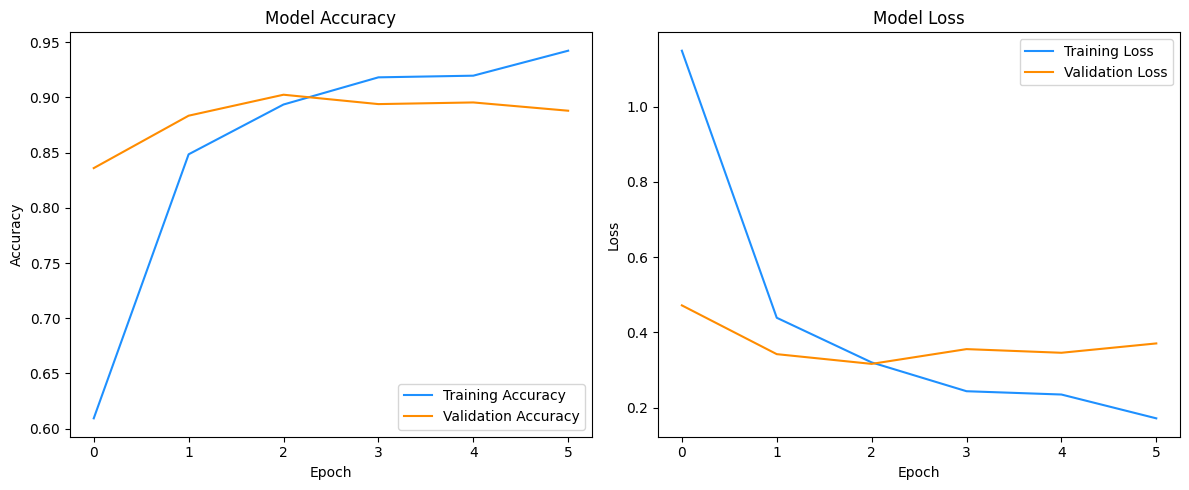

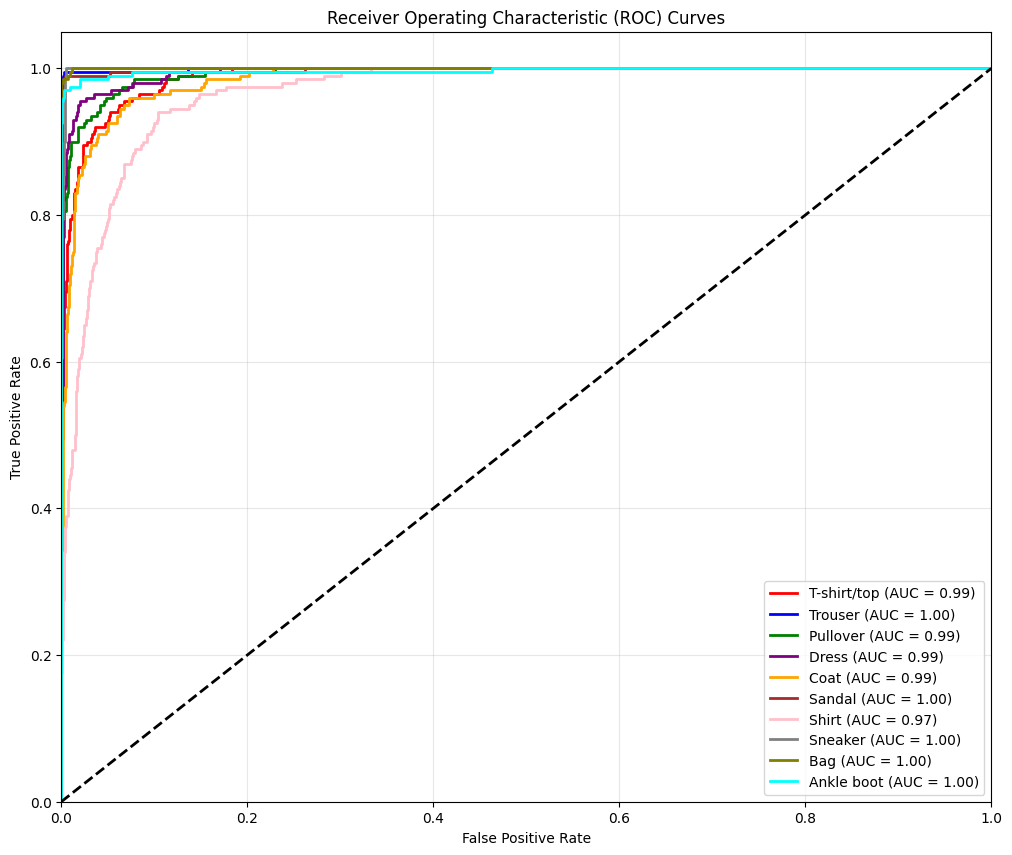

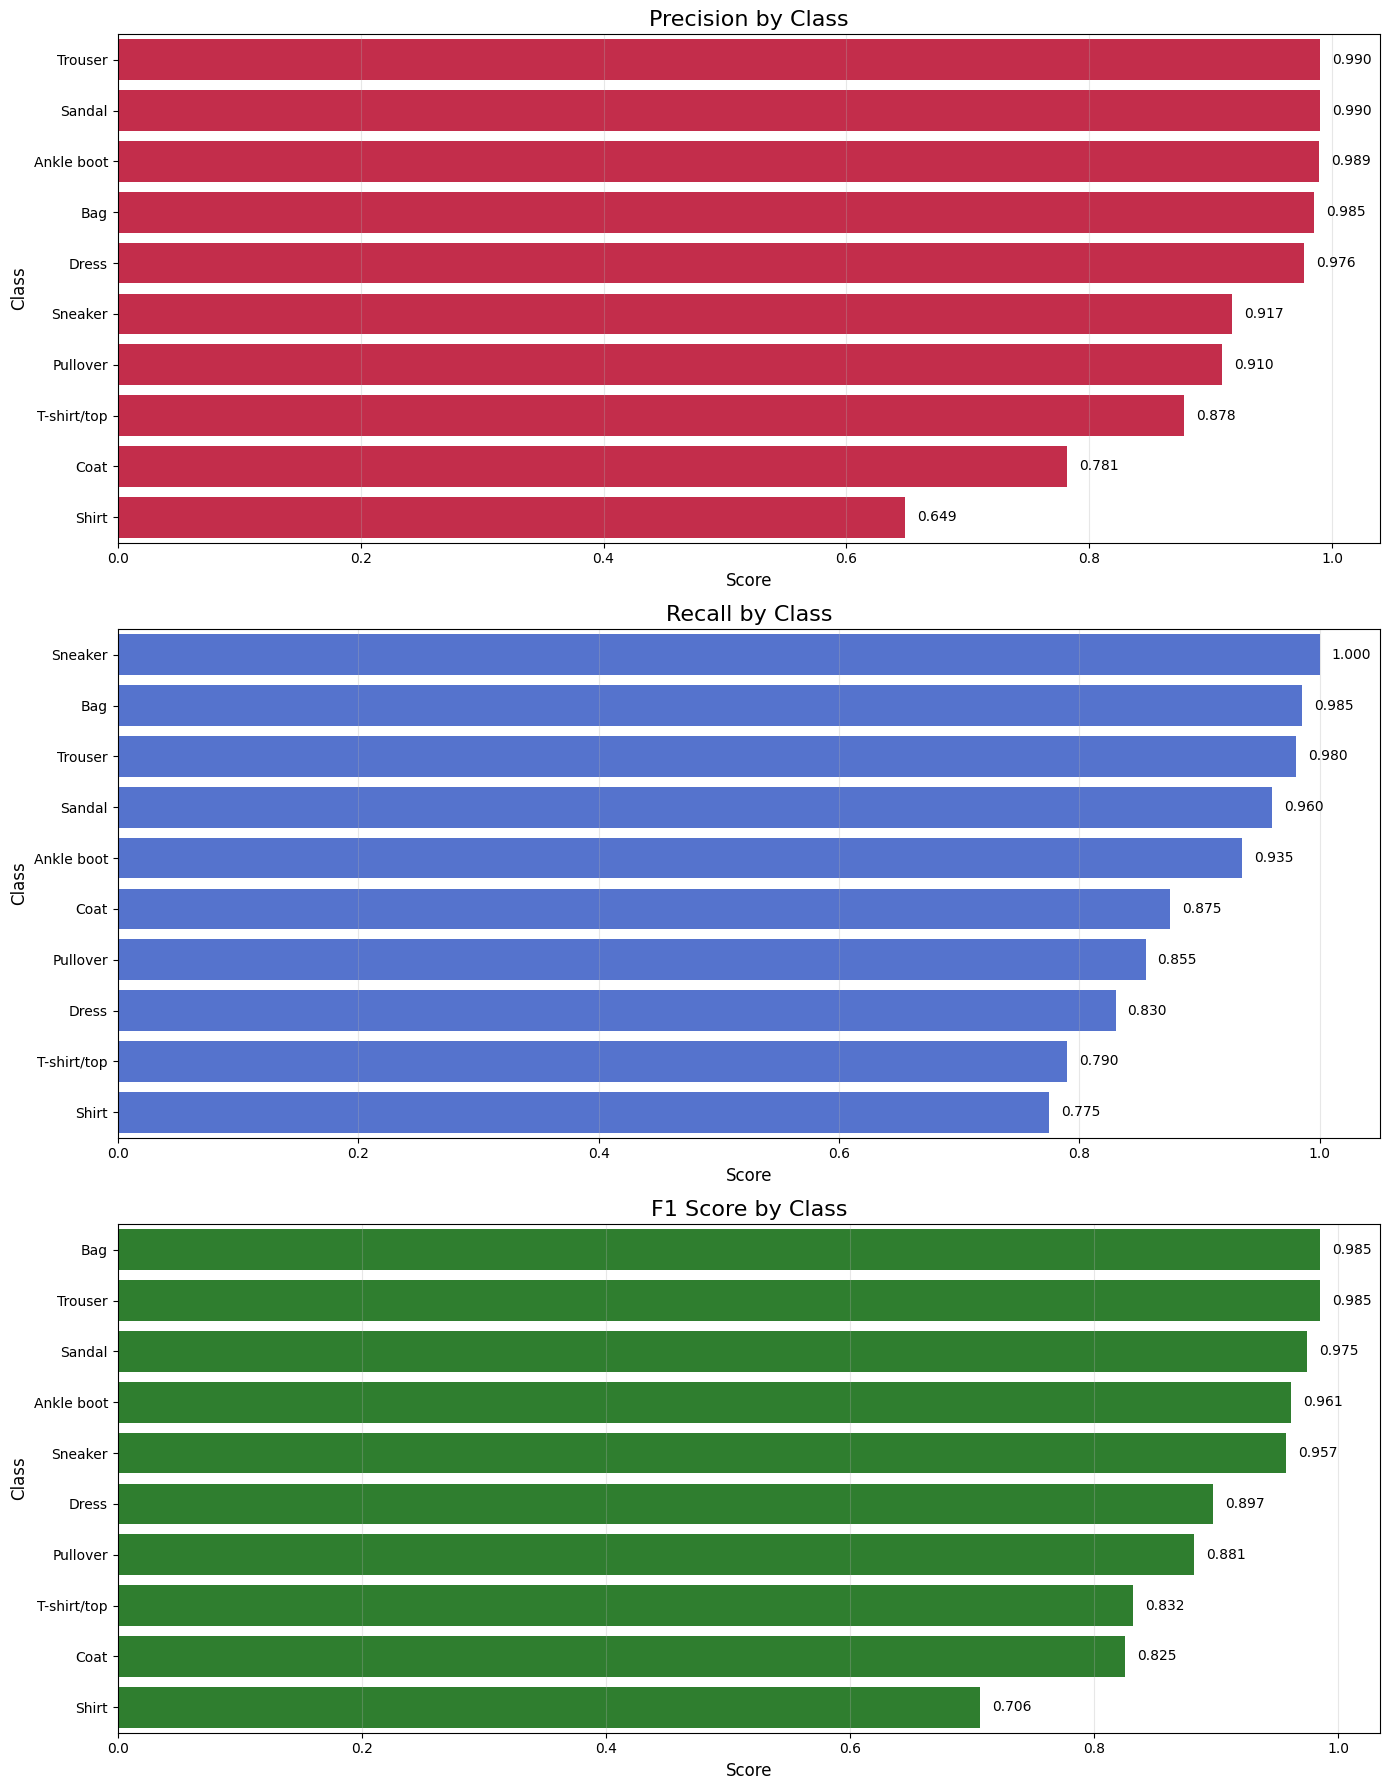

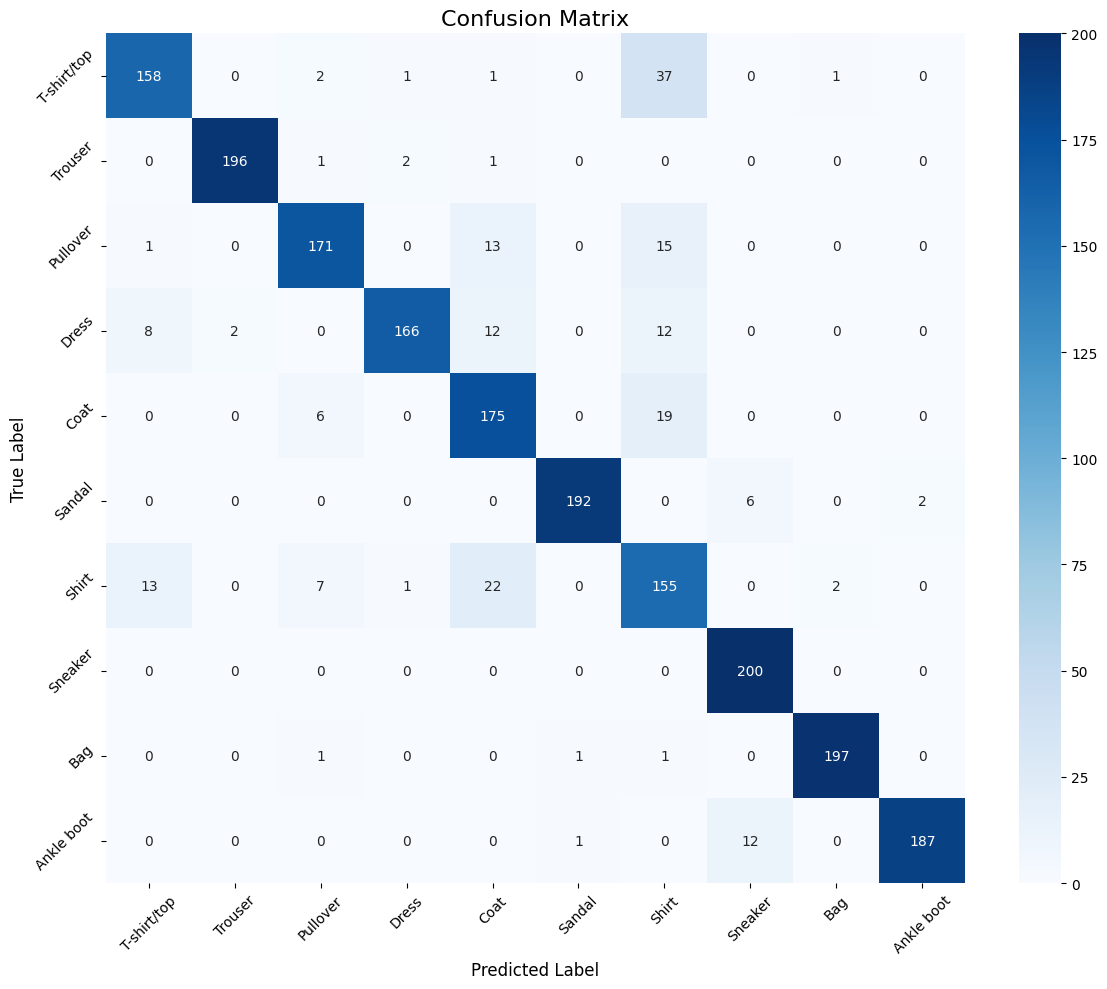


Step 4: Extracting features for similarity search...
Extracting features for all products...
Processed features for 100/12000 products
Processed features for 200/12000 products
Processed features for 300/12000 products
Processed features for 400/12000 products
Processed features for 500/12000 products
Processed features for 600/12000 products
Processed features for 700/12000 products
Processed features for 800/12000 products
Processed features for 900/12000 products
Processed features for 1000/12000 products
Processed features for 1100/12000 products
Processed features for 1200/12000 products
Processed features for 1300/12000 products
Processed features for 1400/12000 products
Processed features for 1500/12000 products
Processed features for 1600/12000 products
Processed features for 1700/12000 products
Processed features for 1800/12000 products
Processed features for 1900/12000 products
Processed features for 2000/12000 products
Processed features for 2100/12000 products
Processed fe

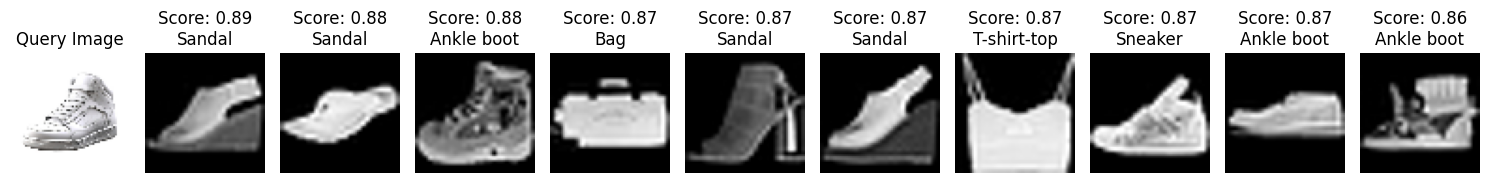

All processing completed!


In [2]:
import numpy as np
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

class FashionCBIR:
    def __init__(self, base_dir, image_size=(64, 64)):  # Reduced image size from 224x224 to 64x64
        self.image_size = image_size
        self.base_dir = base_dir
        self.product_database = []
        self.feature_database = None
        self.history = None
        self.label_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]

        # Make directory if it doesn't exist
        os.makedirs(base_dir, exist_ok=True)

        # Initialize VGG16 model with smaller input size
        self.base_model = VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(image_size[0], image_size[1], 3))

        # Build feature extractor
        self.model = Sequential([
            self.base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.3),
            Dense(256, activation='relu'),
            Dropout(0.2)
        ])

        # Add classification head for evaluation
        self.classifier = Sequential([
            self.model,
            Dense(len(self.label_names), activation='softmax')
        ])

        # Compile the classification model
        self.classifier.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def prepare_fashion_mnist(self, max_images_per_class=1000):
        """Load and prepare Fashion-MNIST dataset with limited images per class"""
        print("Loading Fashion-MNIST dataset...")
        (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

        # Store original labels for evaluation
        self.train_labels = train_labels
        self.test_labels = test_labels

        # Create directories for each category
        for label in self.label_names:
            category_dir = os.path.join(self.base_dir, label.replace("/", "-"))
            os.makedirs(category_dir, exist_ok=True)

        # Process data in smaller batches with limits
        print("Processing training images in batches...")
        self._process_dataset_in_batches(train_images, train_labels, "train", max_images_per_class)

        print("Processing test images in batches...")
        self._process_dataset_in_batches(test_images, test_labels, "test", max_images_per_class // 5)  # Fewer test images

        print(f"Dataset prepared and saved to {self.base_dir}")
        print(f"Total products in database: {len(self.product_database)}")

    def _process_dataset_in_batches(self, images, labels, prefix, max_per_class=1000):
        """Process dataset in batches with count limits per class"""
        # Count images per class
        class_counts = np.zeros(len(self.label_names), dtype=int)

        # Process in batches of 100
        batch_size = 100
        for start_idx in range(0, len(images), batch_size):
            end_idx = min(start_idx + batch_size, len(images))
            batch_images = images[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]

            # Save images that don't exceed per-class limits
            for i, (image, label) in enumerate(zip(batch_images, batch_labels)):
                # Skip if we've reached the maximum for this class
                if class_counts[label] >= max_per_class:
                    continue

                # Increment class counter
                class_counts[label] += 1

                # Process and save image
                img = Image.fromarray(image).convert('RGB')
                img = img.resize(self.image_size)

                category = self.label_names[label].replace("/", "-")
                filename = f'{prefix}{category}{class_counts[label]}.png'
                save_path = os.path.join(self.base_dir, category, filename)
                img.save(save_path)

                product_info = {
                    'image_path': save_path,
                    'category': category,
                    'product_id': f'{prefix}{category}{class_counts[label]}',
                    'label_index': label
                }
                self.product_database.append(product_info)

            # Print progress
            print(f"Processed batch {start_idx//batch_size + 1}/{(len(images)-1)//batch_size + 1}")

            # Check if we've hit all class limits
            if np.all(class_counts >= max_per_class):
                print(f"Reached maximum images per class ({max_per_class}). Stopping processing.")
                break

        # Print summary
        for i, count in enumerate(class_counts):
            print(f"Class {self.label_names[i]}: {count} images processed")

    def preprocess_image(self, image_path):
        """Preprocess image for feature extraction"""
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img)
        # Use VGG16 preprocessing
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def prepare_dataset_for_training(self):
        """Prepare dataset for model training and evaluation"""
        print("Preparing dataset for training and evaluation...")

        # Check if we have enough data
        if len(self.product_database) == 0:
            raise ValueError("Product database is empty. Please run prepare_fashion_mnist first.")

        # Organize into train and test sets
        train_items = [p for p in self.product_database if 'train' in p['product_id']]
        test_items = [p for p in self.product_database if 'test' in p['product_id']]

        print(f"Found {len(train_items)} training items and {len(test_items)} test items")

        # Process in smaller batches to avoid memory issues
        X_train = []
        y_train = []
        X_test = []
        y_test = []

        # Process training data
        print("Loading training images...")
        batch_size = 100
        for i in range(0, len(train_items), batch_size):
            batch = train_items[i:i+batch_size]
            for product in batch:
                try:
                    img_processed = self.preprocess_image(product['image_path'])[0]
                    X_train.append(img_processed)
                    y_train.append(product['label_index'])
                except Exception as e:
                    print(f"Error processing {product['image_path']}: {e}")

            if (i + batch_size) % 500 == 0 or i + batch_size >= len(train_items):
                print(f"Processed {min(i + batch_size, len(train_items))}/{len(train_items)} training images")

        # Process test data
        print("Loading test images...")
        for i in range(0, len(test_items), batch_size):
            batch = test_items[i:i+batch_size]
            for product in batch:
                try:
                    img_processed = self.preprocess_image(product['image_path'])[0]
                    X_test.append(img_processed)
                    y_test.append(product['label_index'])
                except Exception as e:
                    print(f"Error processing {product['image_path']}: {e}")

            if (i + batch_size) % 500 == 0 or i + batch_size >= len(test_items):
                print(f"Processed {min(i + batch_size, len(test_items))}/{len(test_items)} test images")

        # Convert to numpy arrays
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        print(f"Final dataset shapes: X_train={X_train.shape}, X_test={X_test.shape}")

        # Convert labels to one-hot encoding
        y_train_cat = to_categorical(y_train, num_classes=len(self.label_names))
        y_test_cat = to_categorical(y_test, num_classes=len(self.label_names))

        # Create validation set from training set
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train_cat, test_size=0.2, random_state=42
        )

        return X_train_final, X_val, X_test, y_train_final, y_val, y_test_cat, y_test

    def train_model(self, epochs=10, batch_size=32):
        """Train the model and evaluate its performance"""
        print("Training the model...")

        # Prepare datasets for training and evaluation
        X_train, X_val, X_test, y_train, y_val, y_test_cat, y_test = self.prepare_dataset_for_training()

        # Set up callbacks
        checkpoint = ModelCheckpoint(
            filepath='best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )

        # Train the model
        self.history = self.classifier.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[checkpoint, early_stopping],
            verbose=1
        )

        # Evaluate the model
        print("\nEvaluating model on test data...")
        test_loss, test_accuracy = self.classifier.evaluate(X_test, y_test_cat, verbose=1)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Get predictions for calculating metrics
        y_pred_probs = self.classifier.predict(X_test, verbose=1)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calculate precision, recall, and F1 scores
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")
        print(f"F1 Score (weighted): {f1:.4f}")

        # Calculate per-class metrics
        precision_per_class = precision_score(y_test, y_pred, average=None)
        recall_per_class = recall_score(y_test, y_pred, average=None)
        f1_per_class = f1_score(y_test, y_pred, average=None)

        # Save metrics for plotting
        self.class_metrics = {
            'precision': precision_per_class,
            'recall': recall_per_class,
            'f1': f1_per_class
        }

        # Save data for ROC curve plotting
        self.y_test = y_test
        self.y_test_cat = y_test_cat
        self.y_pred_probs = y_pred_probs

        # Save metrics to dictionary
        metrics_dict = {
            'accuracy': test_accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class
        }

        # Save metrics to file
        with open('model_metrics.txt', 'w') as f:
            for key, value in metrics_dict.items():
                if isinstance(value, np.ndarray):
                    f.write(f"{key}:\n")
                    for i, v in enumerate(value):
                        f.write(f"  {self.label_names[i]}: {v:.4f}\n")
                else:
                    f.write(f"{key}: {value:.4f}\n")

        return metrics_dict

    def extract_features(self):
        """Extract features for all products in database"""
        print("Extracting features for all products...")
        features = []
        total_products = len(self.product_database)

        # Process in batches to avoid memory issues
        batch_size = 100
        for i in range(0, total_products, batch_size):
            batch_end = min(i + batch_size, total_products)
            batch = self.product_database[i:batch_end]

            batch_features = []
            for product in batch:
                try:
                    img_processed = self.preprocess_image(product['image_path'])
                    feature_vector = self.model.predict(img_processed, verbose=0)
                    batch_features.append(feature_vector.flatten())
                except Exception as e:
                    print(f"Error extracting features for {product['image_path']}: {e}")
                    # Add a zero vector to maintain indexing
                    batch_features.append(np.zeros(256))

            features.extend(batch_features)
            print(f"Processed features for {batch_end}/{total_products} products")

        self.feature_database = np.array(features)
        print("Feature extraction completed")

        # Save features to file for later use
        try:
            np.save('feature_database.npy', self.feature_database)
            print("Features saved to feature_database.npy")
        except Exception as e:
            print(f"Error saving features: {e}")

    def find_similar_products(self, query_image_path, num_results=10):
        """Find similar products for a given query image"""
        query_processed = self.preprocess_image(query_image_path)
        query_features = self.model.predict(query_processed, verbose=0).flatten()

        similarities = cosine_similarity([query_features], self.feature_database)
        similar_indices = np.argsort(similarities[0])[::-1][:num_results]

        similar_products = []
        for idx in similar_indices:
            product = self.product_database[idx].copy()
            product['similarity_score'] = similarities[0][idx]
            similar_products.append(product)

        return similar_products

    def display_results(self, query_image_path, similar_products):
        """Display query image and similar products"""
        output_dir = '/kaggle/working/'
        os.makedirs(output_dir, exist_ok=True)

        num_results = len(similar_products)  # Number of similar products to display
        plt.figure(figsize=(15, 3 + num_results // 5))  # Adjust the figure size

        # Display query image
        plt.subplot(1, num_results + 1, 1)
        query_img = load_img(query_image_path, target_size=self.image_size)
        plt.imshow(query_img)
        plt.title('Query Image')
        plt.axis('off')

        # Display similar products
        for i, product in enumerate(similar_products):
            plt.subplot(1, num_results + 1, i + 2)
            img = load_img(product['image_path'], target_size=self.image_size)
            plt.imshow(img)
            plt.title(f"Score: {product['similarity_score']:.2f}\n{product['category']}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'similar_products.png'))
        plt.show()

    def plot_training_history(self):
        """Plot the training and validation accuracy/loss"""
        if self.history is None:
            print("No training history found. Please train the model first.")
            return

        plt.figure(figsize=(12, 5))

        # Plot training & validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], 'dodgerblue', label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], 'darkorange', label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], 'dodgerblue', label='Training Loss')
        plt.plot(self.history.history['val_loss'], 'darkorange', label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

    def plot_roc_curves(self):
        """Plot ROC curves for each class"""
        if not hasattr(self, 'y_test_cat') or not hasattr(self, 'y_pred_probs'):
            print("No prediction data found. Please train the model first.")
            return

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        plt.figure(figsize=(12, 10))

        # Colors for each class
        colors = ['red', 'blue', 'green', 'purple', 'orange',
                 'brown', 'pink', 'gray', 'olive', 'cyan']

        for i in range(len(self.label_names)):
            fpr[i], tpr[i], _ = roc_curve(self.y_test_cat[:, i], self.y_pred_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                     label=f'{self.label_names[i]} (AUC = {roc_auc[i]:.2f})')

        # Plot the diagonal line
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        plt.savefig('roc_curves.png')
        plt.show()

    def plot_class_metrics(self):
        """Plot precision, recall and F1 scores for each class"""
        if not hasattr(self, 'class_metrics'):
            print("No class metrics found. Please train the model first.")
            return

        metrics = ['precision', 'recall', 'f1']
        titles = ['Precision by Class', 'Recall by Class', 'F1 Score by Class']
        colors = ['crimson', 'royalblue', 'forestgreen']

        fig, axes = plt.subplots(3, 1, figsize=(14, 18))

        for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
            # Create DataFrame for better plotting
            df = pd.DataFrame({
                'Class': self.label_names,
                'Value': self.class_metrics[metric]
            })

            # Sort by value for better visualization
            df = df.sort_values('Value', ascending=False)

            # Plot bar chart
            sns.barplot(x='Value', y='Class', data=df, ax=axes[i], color=color)
            axes[i].set_title(title, fontsize=16)
            axes[i].set_xlabel('Score', fontsize=12)
            axes[i].set_ylabel('Class', fontsize=12)
            axes[i].grid(True, axis='x', alpha=0.3)

            # Add value labels
            for j, v in enumerate(df['Value']):
                axes[i].text(v + 0.01, j, f"{v:.3f}", va='center')

        plt.tight_layout()
        plt.savefig('class_metrics.png')
        plt.show()

    def plot_confusion_matrix(self):
        """Plot confusion matrix for model evaluation"""
        if not hasattr(self, 'y_test') or not hasattr(self, 'y_pred_probs'):
            print("No prediction data found. Please train the model first.")
            return

        # Get predicted classes
        y_pred = np.argmax(self.y_pred_probs, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_names,
                   yticklabels=self.label_names)
        plt.title('Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)

        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

    def evaluate_and_visualize(self):
        """Run all evaluation and visualization methods"""
        self.plot_training_history()
        self.plot_roc_curves()
        self.plot_class_metrics()
        self.plot_confusion_matrix()

def main():
    base_dir = '/content/sample_data/fashion_mnist_images'  # Store in working directory

    # Initialize CBIR system with VGG16 and smaller image size
    cbir = FashionCBIR(base_dir=base_dir, image_size=(64, 64))

    # Prepare Fashion-MNIST dataset (only needed once)
    # Limit to 1000 images per class to avoid resource issues
    print("Step 1: Preparing Fashion-MNIST dataset...")
    cbir.prepare_fashion_mnist(max_images_per_class=1000)

    # Train and evaluate the model
    print("\nStep 2: Training and evaluating the model...")
    metrics = cbir.train_model(epochs=10, batch_size=32)

    # Visualize all evaluation metrics
    print("\nStep 3: Visualizing evaluation metrics...")
    cbir.evaluate_and_visualize()

    # Extract features for all products
    print("\nStep 4: Extracting features for similarity search...")
    cbir.extract_features()

    # Example: Find similar products for a query image
    # Check if provided query image exists, otherwise use a test image from our dataset
    query_image_path = '/content/sample_data/sneaker.jpg'  # Default path
    if not os.path.exists(query_image_path):
        print(f"Query image not found at {query_image_path}, using a sample test image instead")
        # Find a sneaker from our test set
        sneaker_products = [p for p in cbir.product_database if "Sneaker" in p['category'] and 'test' in p['product_id']]
        if sneaker_products:
            query_image_path = sneaker_products[0]['image_path']
            print(f"Using {query_image_path} as query image")
        else:
            # Just use the first test image
            test_products = [p for p in cbir.product_database if 'test' in p['product_id']]
            if test_products:
                query_image_path = test_products[0]['image_path']
                print(f"Using {query_image_path} as query image")

    # Find similar products
    similar_products = cbir.find_similar_products(query_image_path, num_results=10)

    # Display results
    cbir.display_results(query_image_path, similar_products)

    print("All processing completed!")

if __name__ == "__main__":
    main()